In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy
#from mpl_toolkits.axes_grid1 import make
#_axes_locatable
%matplotlib inline
from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches

In [157]:
_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

In [158]:
year=2008
ds_w = xr.open_mfdataset('/net/seldon/disk1/Data/CERES/SYN1deg-Hour-Ed4/'+str(year)+'/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Total_*.nc',combine = 'by_coords', concat_dim="time")
swall = ds_w['toa_sw_all_1h'][:]
swclr = ds_w['toa_sw_clr_1h'][:]
lwall = ds_w['toa_lw_all_1h'][:]
lwclr = ds_w['toa_lw_clr_1h'][:]
netall = ds_w['toa_net_all_1h'][:]
netclr = ds_w['toa_net_clr_1h'][:]
solar = ds_w['toa_solar_all_1h'][:]
timeceres = ds_w['time'][:]
cf = ds_w['cldarea_total_1h'][:]

In [159]:
isccp = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/200*.nc',combine='nested',concat_dim='time')
taupc = isccp['n_pctaudist']
levtau = isccp['levtau']
levpc = isccp['levpc']
tauraw = isccp['tau']
pcraw = isccp['pc']
isccptime = isccp['time']
offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))
alb_all = ds_w['toa_alb_all_1h'][:]
alb_clr = ds_w['toa_alb_clr_1h'][:]


In [160]:
import warnings
print('is it doing?')
timelen=499
yedges_net = np.arange(-650,650,1)
yedges_lw = np.arange(-500,0,1)
yedges_sw = np.arange(-100,900,1)
yedges_solar = np.arange(0,1400,5)
xedges = np.arange(0,timelen+1,1)

cereshour = 8760
k=0
year = 2008

tsc = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62]
landocean = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62]
aodtsc = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvAOD'][:,2:62]
detinsit = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62]

isccp = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/200*.nc',combine='nested',concat_dim='time')
taupc = isccp['n_pctaudist']
levtau = isccp['levtau']
levpc = isccp['levpc']
tauraw = isccp['tau']
pcraw = isccp['pc']
isccptime = isccp['time']

ds_w = xr.open_mfdataset('/net/seldon/disk1/Data/CERES/SYN1deg-Hour-Ed4/'+str(year)+'/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Total_*.nc',combine = 'by_coords', concat_dim="time")
swall = ds_w['toa_sw_all_1h'][:]
swclr = ds_w['toa_sw_clr_1h'][:]
lwall = ds_w['toa_lw_all_1h'][:]
lwclr = ds_w['toa_lw_clr_1h'][:]
netall = ds_w['toa_net_all_1h'][:]
netclr = ds_w['toa_net_clr_1h'][:]
solar = ds_w['toa_solar_all_1h'][:]
timeceres = ds_w['time'][:]
cf = ds_w['cldarea_total_1h'][:]

swcldycalc = -(swall[0::3][0:len(isccp['time'][offset:])] - swclr[0::3][0:len(isccp['time'][offset:])])

offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))

meanlw = np.nanmean(lwclr[:],axis=0)
levels = 4
lowcldamt = 1

lowcloudraw = np.nansum(isccp['n_pcdist'][offset:,:levels,60:120],axis=1)
lowcloud_day = np.where(lowcloudraw<0,np.nan,lowcloudraw)

solar_t = solar[0::3][0:len(isccp['time'][offset:])]
alb_all_t = alb_all[0::3][0:len(isccp['time'][offset:])]
alb_clr_t = alb_clr[0::3][0:len(isccp['time'][offset:])]

alb_all_t_sm = np.where(solar_t<700,np.nan,alb_all_t) 
alb_clr_t_sm = np.where(solar_t<700,np.nan,alb_clr_t)
solar_t_sm = np.where(solar_t<700,np.nan,solar_t)

low_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm - alb_clr_t_sm,np.nan)
bkg_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm,np.nan)

alb_high_low = alb_all_t - (alb_clr_t + np.nanmean(low_alb,axis=0))
alb_high_low = np.where(np.isnan(alb_high_low),0,alb_high_low)
alb_high_bkg = alb_all_t - np.nanmean(bkg_alb,axis=0)
alb_high_bkg = np.where(np.isnan(alb_high_bkg),0,alb_high_bkg)

lwclr_f = np.where(np.isnan(lwclr[0::3][0:len(isccp['time'][offset:])]),meanlw,lwclr[0::3][0:len(isccp['time'][offset:])])
lwcldy = (lwall[0::3][0:len(isccp['time'][offset:])] - lwclr_f) 
swcldy = solar_t*alb_high_low
swcldy_bkg = solar_t*alb_high_bkg

swcldyzerobkg = np.where(swcldy_bkg<0,0,swcldy_bkg)
swcldyzeroall = np.where(swcldy<0,0,swcldy)

tsc_t = (np.asarray(tsc[offset*3::3]))
tsc_d = np.asarray(np.where(detinsit[offset*3::3]>=0,tsc[offset*3::3],np.nan))
tsc_i = np.asarray(np.where(np.isnan(tsc_d),tsc[offset*3::3],np.nan))
tsc_o = np.asarray(np.where(landocean[offset*3::3]<0,tsc[offset*3::3],np.nan))
tsc_l = np.asarray(np.where(landocean[offset*3::3]>0,tsc[offset*3::3],np.nan))

tsc_o_d = np.asarray(np.where(landocean[offset*3::3]<0,tsc_d,np.nan))
tsc_o_i = np.asarray(np.where(landocean[offset*3::3]<0,tsc_i,np.nan))

tsc_l_d = np.asarray(np.where(landocean[offset*3::3]>0,tsc_d,np.nan))
tsc_l_i = np.asarray(np.where(landocean[offset*3::3]>0,tsc_i,np.nan))


H_lw, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw)) 
H_sw, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

H_sw_det, xedges, yedges_sw = np.histogram2d(tsc_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
H_sw_ins, xedges, yedges_sw = np.histogram2d(tsc_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

H_lw_det, xedges, yedges_lw = np.histogram2d(tsc_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
H_lw_ins, xedges, yedges_lw = np.histogram2d(tsc_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

H_lw_l, xedges, yedges_lw = np.histogram2d(tsc_l.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
H_sw_l, xedges, yedges_sw = np.histogram2d(tsc_l.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

H_lw_o, xedges, yedges_lw = np.histogram2d(tsc_o.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
H_sw_o, xedges, yedges_sw = np.histogram2d(tsc_o.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

H_lw_o_det, xedges, yedges_lw = np.histogram2d(tsc_o_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
H_lw_o_ins, xedges, yedges_lw = np.histogram2d(tsc_o_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

H_lw_l_det, xedges, yedges_lw = np.histogram2d(tsc_l_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
H_lw_l_ins, xedges, yedges_lw = np.histogram2d(tsc_l_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

H_sw_o_det, xedges, yedges_sw = np.histogram2d(tsc_o_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
H_sw_o_ins, xedges, yedges_sw = np.histogram2d(tsc_o_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

H_sw_l_det, xedges, yedges_sw = np.histogram2d(tsc_l_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
H_sw_l_ins, xedges, yedges_sw = np.histogram2d(tsc_l_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

is it doing?


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


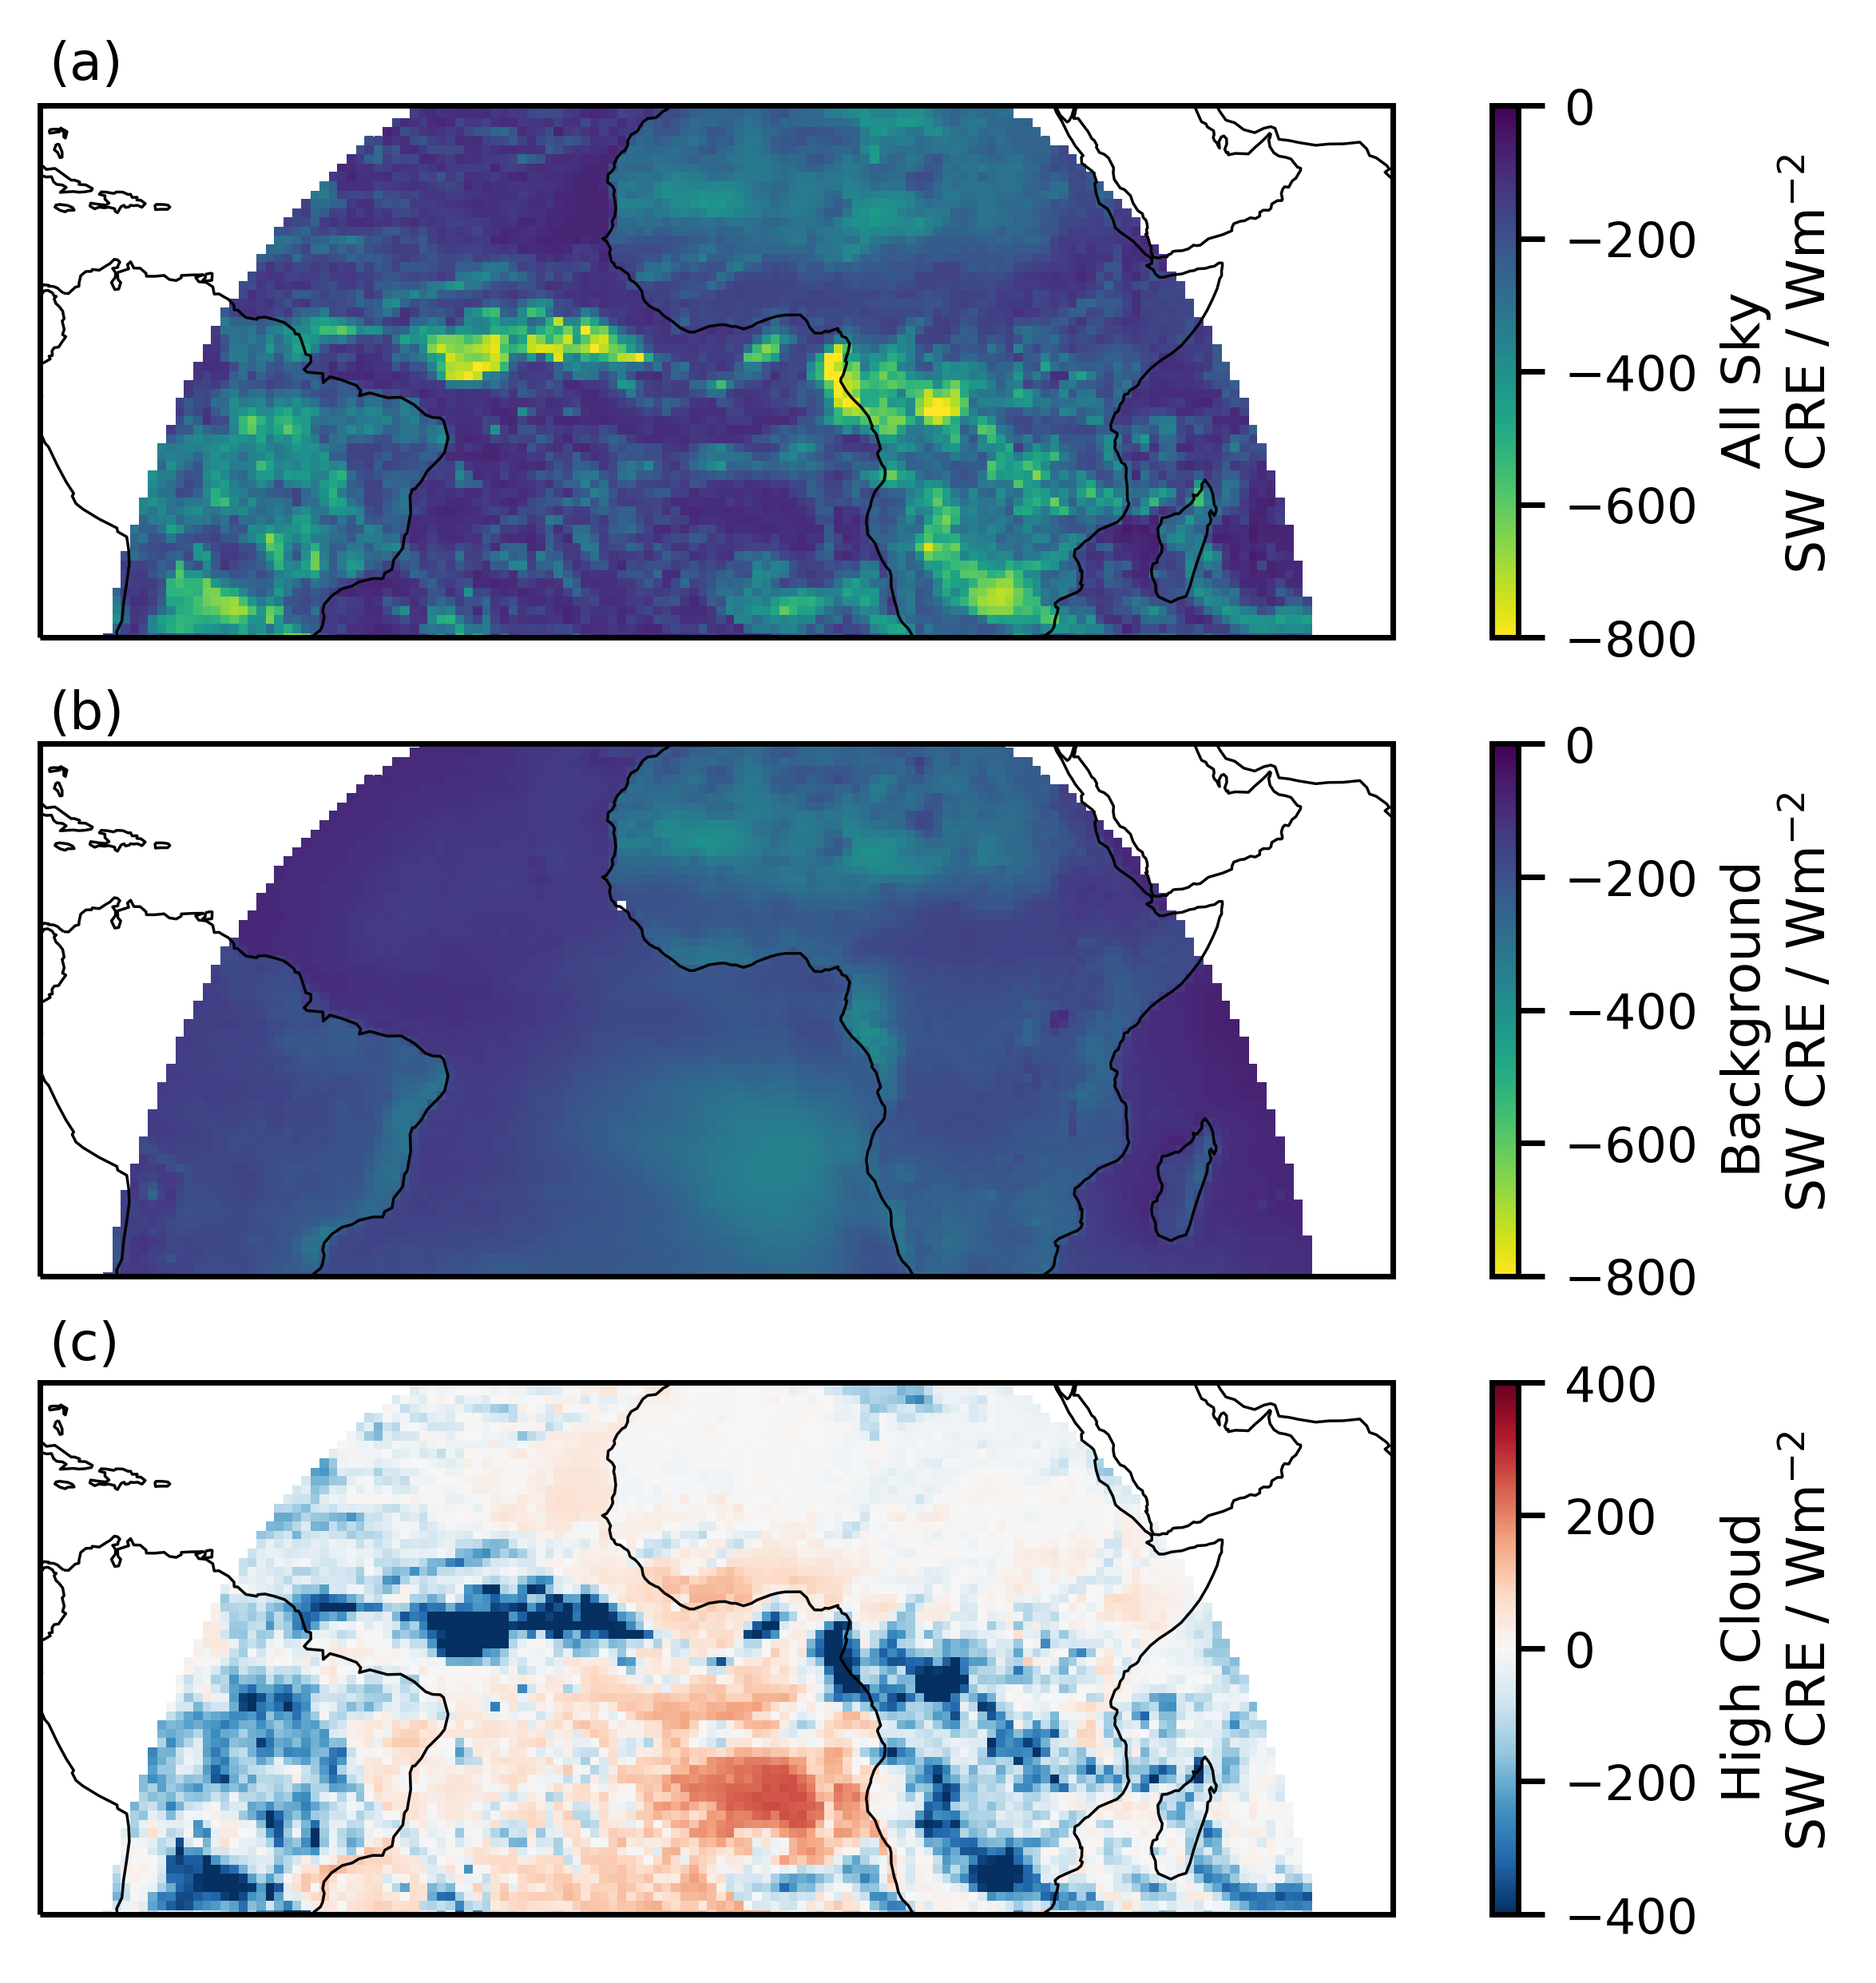

In [88]:
frac = 0.2245
pa = 0.04
img_extent = (-180, 180, -30, 30)
fig = plt.figure(figsize=(8,6),dpi=500)
import seaborn as sns 
sns.set_context('paper')
gs = fig.add_gridspec(3, 1)
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())

ax0.set_extent([-80,70,-29.5,29.5], crs=ccrs.PlateCarree())
ax0.coastlines(resolution='auto', color='k',linewidth=0.5)
im0 = ax0.imshow(- solar_t_sm[12]*alb_all_t_sm[12,:,:],interpolation='none',vmax=0,vmin=-800,origin='lower',extent=img_extent,cmap='viridis_r',transform=ccrs.PlateCarree(central_longitude=180))
plt.colorbar(im0,ax=ax0,orientation='vertical',label='All Sky \n SW CRE / Wm$^{-2}$',fraction=frac, pad=pa)


ax1.set_extent([-80,70,-29.5,29.5], crs=ccrs.PlateCarree())
ax1.coastlines(resolution='auto', color='k',linewidth=0.5)
im1 = ax1.imshow(- solar_t_sm[12]*np.nanmean(bkg_alb[:,:,:],axis=0),interpolation='none',vmax=0,vmin=-800,origin='lower',extent=img_extent,cmap='viridis_r',transform=ccrs.PlateCarree(central_longitude=180))
plt.colorbar(im1,ax=ax1,orientation='vertical',label='Background \n SW CRE / Wm$^{-2}$',fraction=frac, pad=pa)

ax2.set_extent([-80,70,-29.5,29.5], crs=ccrs.PlateCarree())
ax2.coastlines(resolution='auto', color='k',linewidth=0.5)
im2 = ax2.imshow(- solar_t_sm[12]*(alb_all_t_sm[12] -  np.nanmean(bkg_alb[:,:,:],axis=0)),interpolation='none',vmax=400,vmin=-400,origin='lower',extent=img_extent,cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=180))
plt.colorbar(im2,ax=ax2,orientation='vertical',label='High Cloud \n SW CRE / Wm$^{-2}$',fraction=frac, pad=pa)

plt.text(-79,174,'(a)')
plt.text(-79,102,'(b)')
plt.text(-79,32,'(c)')

plt.savefig('/disk1/Users/gah20/LifeTimePaper/CRE_Background.pdf',dpi=600,bbox_inches='tight')


In [6]:
timelen=499

H_norm_lw_all = np.zeros((timelen,499))
H_norm_sw_all = np.zeros((timelen,999))

H_norm_lw_o = np.zeros((timelen,499))
H_norm_sw_o = np.zeros((timelen,999))

H_norm_lw_l = np.zeros((timelen,499))
H_norm_sw_l = np.zeros((timelen,999))

H_norm_sw_det = np.zeros((timelen,999))
H_norm_sw_ins = np.zeros((timelen,999))

H_norm_lw_det = np.zeros((timelen,499))
H_norm_lw_ins = np.zeros((timelen,499))

H_norm_lw_o_det = np.zeros((timelen,499))
H_norm_lw_o_ins = np.zeros((timelen,499))

H_norm_lw_l_det = np.zeros((timelen,499))
H_norm_lw_l_ins = np.zeros((timelen,499))

H_norm_sw_o_det = np.zeros((timelen,999))
H_norm_sw_o_ins = np.zeros((timelen,999))

H_norm_sw_l_det = np.zeros((timelen,999))
H_norm_sw_l_ins = np.zeros((timelen,999))



for i in range(timelen):

    H_norm_lw_all[i] = H_lw[i] / np.sum(H_lw[i])
    H_norm_sw_all[i] = H_sw[i] / np.sum(H_sw[i])

    H_norm_lw_o[i] = H_lw_o[i] / np.sum(H_lw_o[i])
    H_norm_sw_o[i] = H_sw_o[i] / np.sum(H_sw_o[i])

    H_norm_lw_l[i] = H_lw_l[i] / np.sum(H_lw_l[i])
    H_norm_sw_l[i] = H_sw_l[i] / np.sum(H_sw_l[i])

    H_norm_sw_det[i] = H_sw_det[i] / np.sum(H_sw_det[i])
    H_norm_sw_ins[i] = H_sw_ins[i] / np.sum(H_sw_ins[i])

    H_norm_lw_det[i] = H_lw_det[i] / np.sum(H_lw_det[i])
    H_norm_lw_ins[i] = H_lw_ins[i] / np.sum(H_lw_ins[i])

    H_norm_lw_o_det[i] = H_lw_o_det[i] / np.sum(H_lw_o_det[i])
    H_norm_lw_o_ins[i] = H_lw_o_ins[i] / np.sum(H_lw_o_ins[i])

    H_norm_lw_l_det[i] = H_lw_l_det[i] / np.sum(H_lw_l_det[i])
    H_norm_lw_l_ins[i] = H_lw_l_ins[i] / np.sum(H_lw_l_ins[i])

    H_norm_sw_o_det[i] = H_sw_o_det[i] / np.sum(H_sw_o_det[i])
    H_norm_sw_o_ins[i] = H_sw_o_ins[i] / np.sum(H_sw_o_ins[i])

    H_norm_sw_l_det[i] = H_sw_l_det[i] / np.sum(H_sw_l_det[i])
    H_norm_sw_l_ins[i] = H_sw_l_ins[i] / np.sum(H_sw_l_ins[i])

LW_AVERAGE_all = np.zeros((timelen))
SW_AVERAGE_all = np.zeros((timelen))

LW_AVERAGE_o = np.zeros((timelen))
SW_AVERAGE_o = np.zeros((timelen))

LW_AVERAGE_l = np.zeros((timelen))
SW_AVERAGE_l = np.zeros((timelen))


SW_AVERAGE_det = np.zeros((timelen))
SW_AVERAGE_ins = np.zeros((timelen))

LW_AVERAGE_det = np.zeros((timelen))
LW_AVERAGE_ins = np.zeros((timelen))

LW_AVERAGE_o_det = np.zeros((timelen))
LW_AVERAGE_o_ins = np.zeros((timelen))

LW_AVERAGE_l_det = np.zeros((timelen))
LW_AVERAGE_l_ins = np.zeros((timelen))

SW_AVERAGE_o_det = np.zeros((timelen))
SW_AVERAGE_o_ins = np.zeros((timelen))

SW_AVERAGE_l_det = np.zeros((timelen))
SW_AVERAGE_l_ins = np.zeros((timelen))



for i in range(timelen):
    LW_AVERAGE_all[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all[i])
    SW_AVERAGE_all[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all[i])

    LW_AVERAGE_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o[i])
    SW_AVERAGE_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o[i])

    LW_AVERAGE_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l[i])
    SW_AVERAGE_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l[i])

    SW_AVERAGE_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det[i])
    SW_AVERAGE_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins[i])

    LW_AVERAGE_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det[i])
    LW_AVERAGE_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins[i])

    LW_AVERAGE_o_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_det[i])
    LW_AVERAGE_o_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_ins[i])

    LW_AVERAGE_l_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_det[i])
    LW_AVERAGE_l_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_ins[i])

    SW_AVERAGE_o_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_det[i])
    SW_AVERAGE_o_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_ins[i])

    SW_AVERAGE_l_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_det[i])
    SW_AVERAGE_l_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_ins[i])
    



/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/

In [162]:
counts = np.histogram(np.asarray(tsc_t).flatten(),bins=np.arange(0,500,1))[0]
counts_det = np.histogram(np.asarray(tsc_d).flatten(),bins=np.arange(0,500,1))[0]
counts_ins = np.histogram(np.asarray(tsc_i).flatten(),bins=np.arange(0,500,1))[0]

counts_o = np.histogram(np.asarray(tsc_o).flatten(),bins=np.arange(0,500,1))[0]
counts_l = np.histogram(np.asarray(tsc_l).flatten(),bins=np.arange(0,500,1))[0]

counts_det_o = np.histogram(np.asarray(tsc_o_d).flatten(),bins=np.arange(0,500,1))[0]
counts_ins_o = np.histogram(np.asarray(tsc_o_i).flatten(),bins=np.arange(0,500,1))[0]

counts_det_l = np.histogram(np.asarray(tsc_l_d).flatten(),bins=np.arange(0,500,1))[0]
counts_ins_l = np.histogram(np.asarray(tsc_l_i).flatten(),bins=np.arange(0,500,1))[0]

weightedlw = (LW_AVERAGE_det * (counts_det / counts)) + (LW_AVERAGE_ins * (counts_ins/counts))
weightedsw = (SW_AVERAGE_det * (counts_det / counts)) + (SW_AVERAGE_ins * (counts_ins/counts))

weightedlw_o = (LW_AVERAGE_o_det * (counts_det_o / counts_o)) + (LW_AVERAGE_o_ins * (counts_ins_o/counts_o))
weightedsw_o = (SW_AVERAGE_o_det * (counts_det_o / counts_o)) + (SW_AVERAGE_o_ins * (counts_ins_o/counts_o))

weightedlw_l = (LW_AVERAGE_l_det * (counts_det_l / counts_l)) + (LW_AVERAGE_l_ins * (counts_ins_l/counts_l))
weightedsw_l = (SW_AVERAGE_l_det * (counts_det_l / counts_l)) + (SW_AVERAGE_l_ins * (counts_ins_l/counts_l))

weightedlw = np.where(np.isnan(weightedlw),LW_AVERAGE_all,weightedlw)
weightedsw = np.where(np.isnan(weightedsw),SW_AVERAGE_all,weightedsw)

weightedlw_o = np.where(np.isnan(weightedlw_o),LW_AVERAGE_o,weightedlw_o)
weightedsw_o = np.where(np.isnan(weightedsw_o),SW_AVERAGE_o,weightedsw_o)

weightedlw_l = np.where(np.isnan(weightedlw_l),LW_AVERAGE_l,weightedlw_l)
weightedsw_l = np.where(np.isnan(weightedsw_l),SW_AVERAGE_l,weightedsw_l)

lwsum = np.nansum(weightedlw[:]*(counts[:]))/np.nansum(counts[:])
swsum = np.nansum(weightedsw[:]*(counts[:]))/np.nansum(counts[:])

lwsum_o = np.nansum(weightedlw_o[:]*(counts_o[:]))/np.nansum(counts_o[:])
swsum_o = np.nansum(weightedsw_o[:]*(counts_o[:]))/np.nansum(counts_o[:])

lwsum_l = np.nansum(weightedlw_l[:]*(counts_l[:]))/np.nansum(counts_l[:])
swsum_l = np.nansum(weightedsw_l[:]*(counts_l[:]))/np.nansum(counts_l[:])


totalforcing = lwsum+swsum

totalforcing_o = lwsum_o+swsum_o

totalforcing_l = lwsum_l+swsum_l


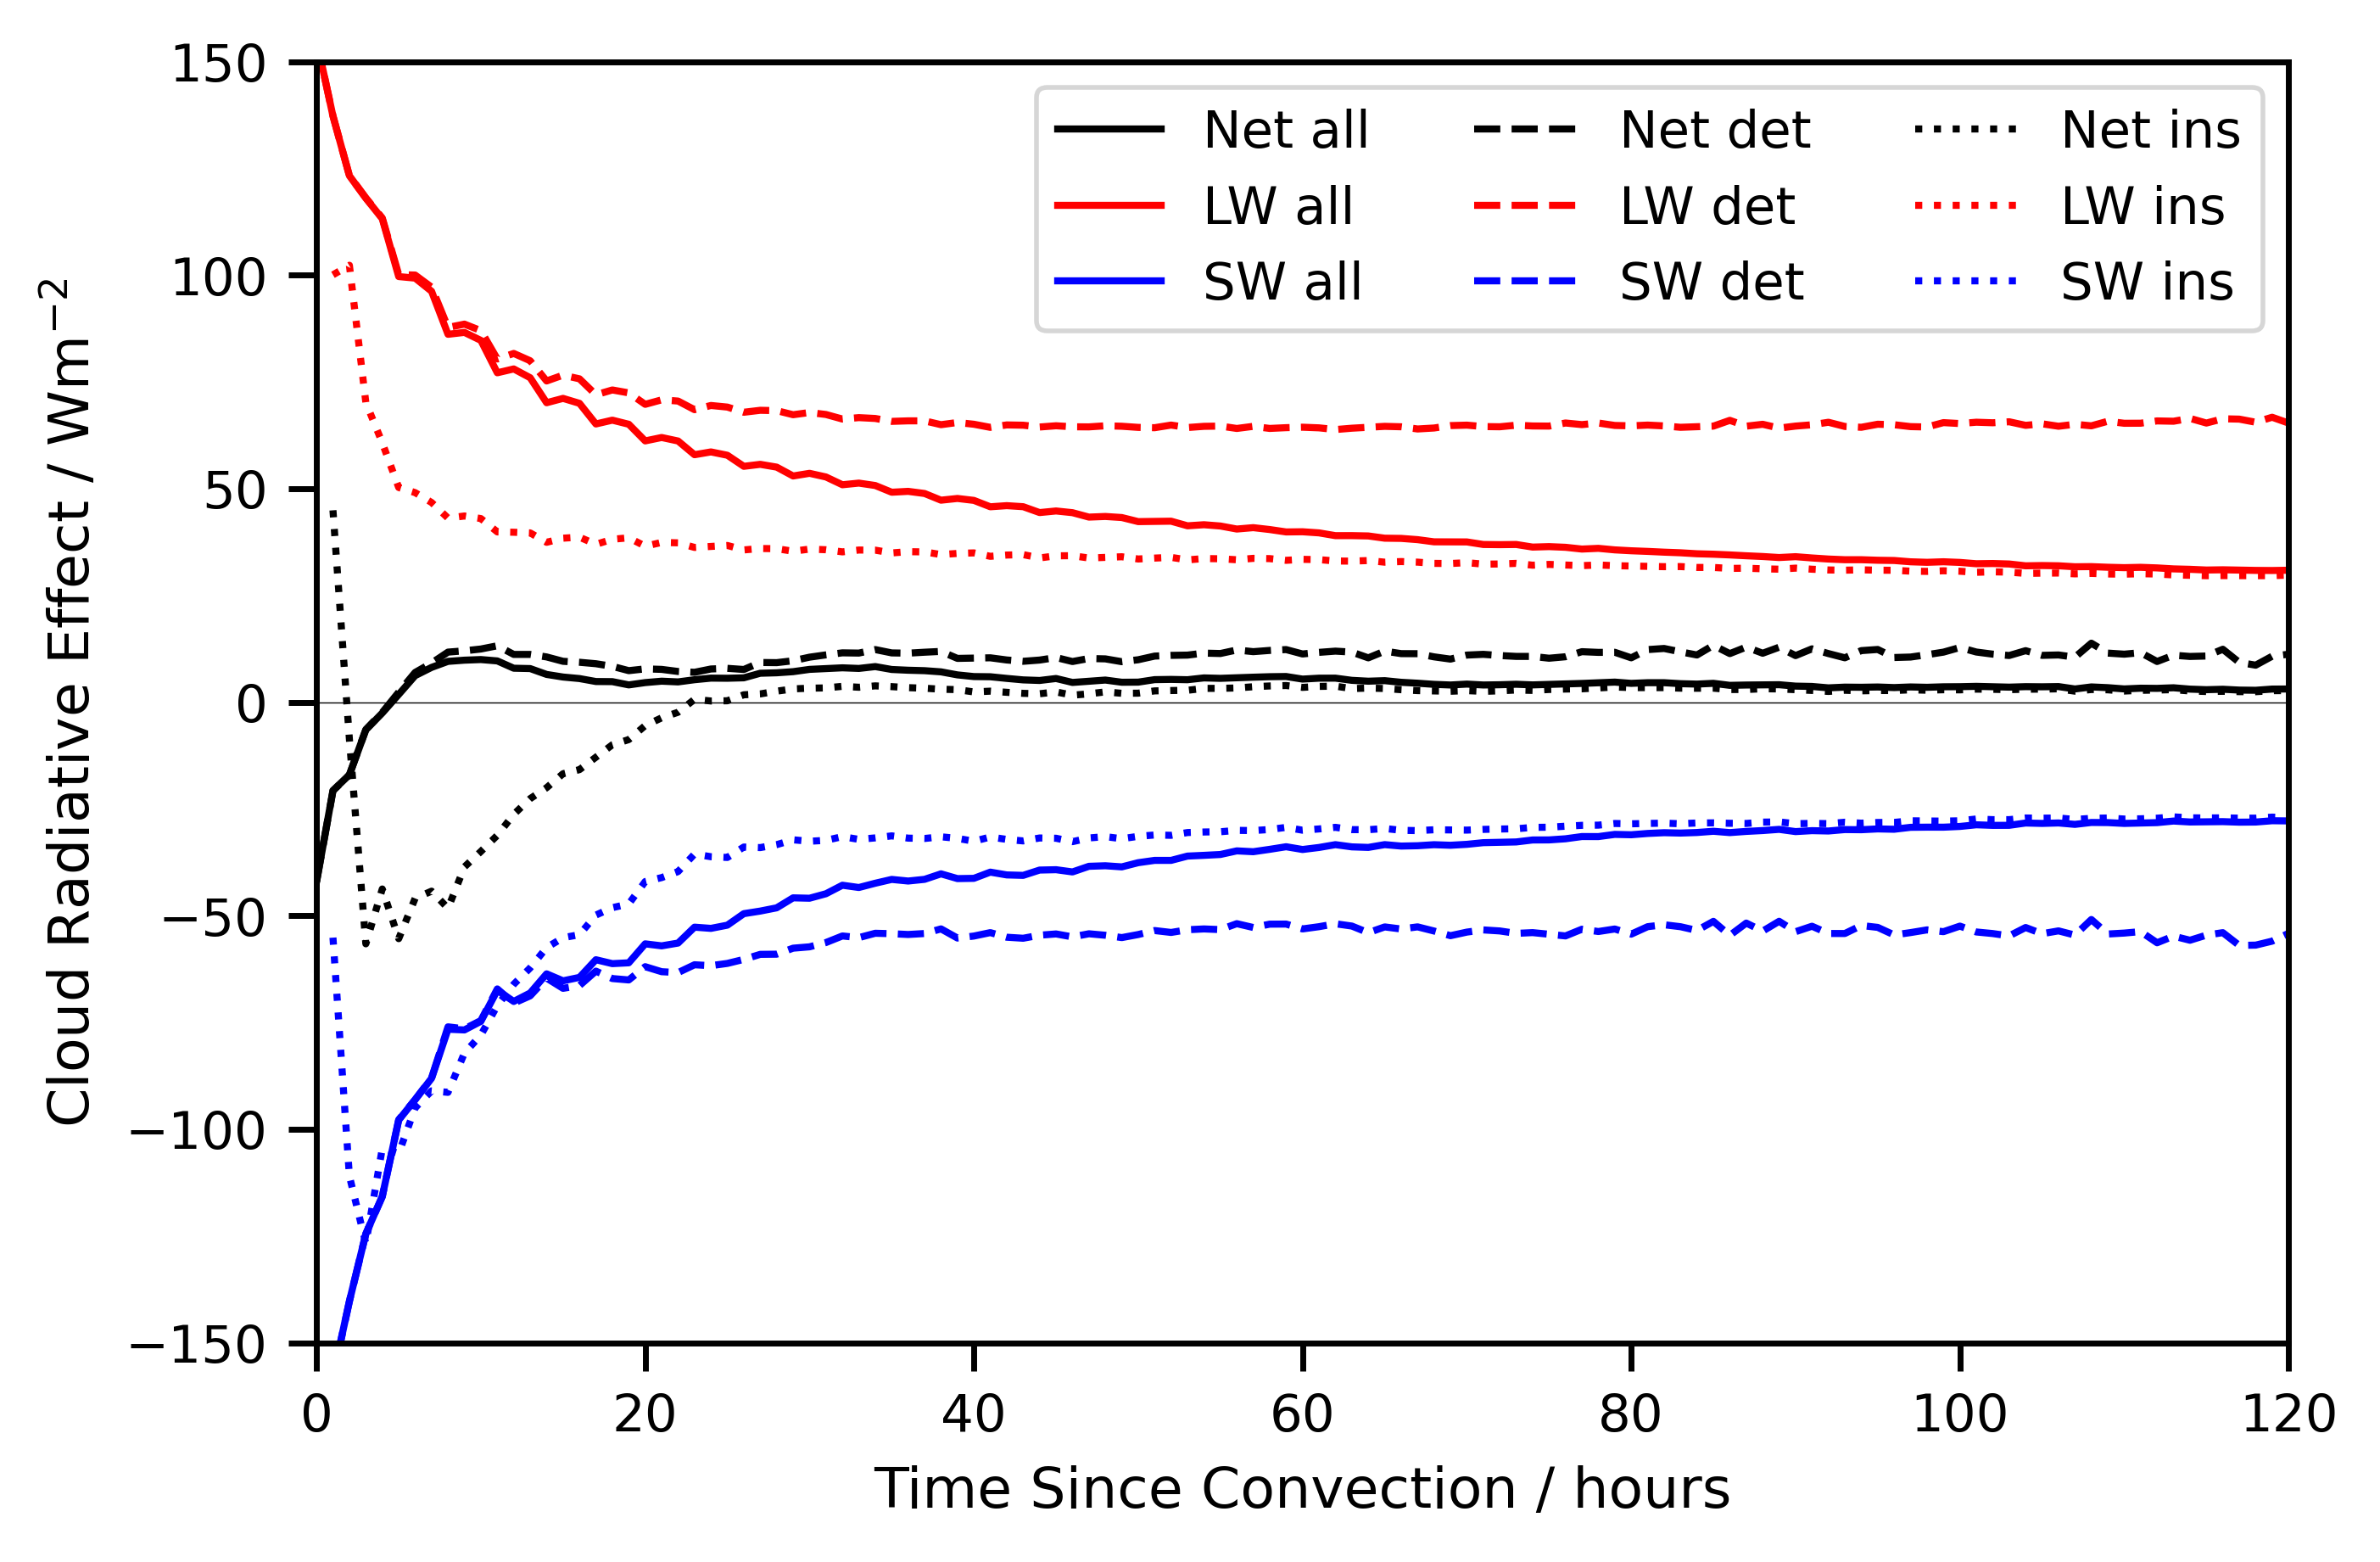

In [11]:
import seaborn as sns
plt.figure(dpi=500)
sns.set_context('paper')
plt.plot(LW_AVERAGE_all+SW_AVERAGE_all,label='Net all',color='black')
plt.plot(LW_AVERAGE_all, label='LW all',color='red')
plt.plot(SW_AVERAGE_all, label='SW all',color='blue')

plt.plot(LW_AVERAGE_det + SW_AVERAGE_det, label='Net det',color='black',linestyle='dashed')
plt.plot(LW_AVERAGE_det, label='LW det',linestyle='dashed',color='red')
plt.plot(SW_AVERAGE_det, label='SW det',linestyle='dashed',color='blue')

plt.plot(LW_AVERAGE_ins + SW_AVERAGE_ins, label='Net ins',color='black',linestyle='dotted')
plt.plot(LW_AVERAGE_ins, label='LW ins',linestyle='dotted',color='red')
plt.plot(SW_AVERAGE_ins, label='SW ins',linestyle='dotted',color='blue')

plt.legend(ncol=3)

plt.ylim(-150,150)
plt.axhline(0,color='k',linewidth=0.2)
plt.xlim(0,120)
plt.xlabel('Time Since Convection / hours')
plt.ylabel('Cloud Radiative Effect / Wm$^{-2}$')
plt.savefig('forcing_albedo_all.pdf',bbox_inches='tight')

In [1]:
totalforcing = []
totalforcing_land = []
totalforcing_ocean = []

totalextcounts = np.zeros((100,499))
totalextcounts_det = np.zeros((100,499))
totalextcounts_ins = np.zeros((100,499))

totalextcounts_o = np.zeros((100,499))
totalextcounts_l = np.zeros((100,499))
totalextcounts_o_d = np.zeros((100,499))
totalextcounts_l_d = np.zeros((100,499))
totalextcounts_o_i =  np.zeros((100,499))
totalextcounts_l_i = np.zeros((100,499))

for i in range(100,200):
    xloc = (np.arange(len(counts_det)))
    newsize = int((len(counts_det)*(i/100)))
    new_xloc = np.linspace(0, len(counts_det), newsize)
    extcounts_det = np.interp(new_xloc, xloc, counts_det)
    extcounts_ins = np.interp(new_xloc, xloc, counts_ins)
    extcounts = np.interp(new_xloc, xloc, counts)

    extcounts_o = np.interp(new_xloc, xloc, counts_o)
    extcounts_l = np.interp(new_xloc, xloc, counts_l)
    extcounts_o_d = np.interp(new_xloc, xloc, counts_det_o)
    extcounts_l_d = np.interp(new_xloc, xloc, counts_det_l)
    extcounts_o_i = np.interp(new_xloc, xloc, counts_ins_o)
    extcounts_l_i = np.interp(new_xloc, xloc, counts_ins_l)


    weightedlw = (LW_AVERAGE_det * (extcounts_det[0:499] / extcounts[0:499])) + (LW_AVERAGE_ins * (extcounts_ins[0:499]/extcounts[0:499]))
    weightedsw = (SW_AVERAGE_det * (extcounts_det[0:499] / extcounts[0:499])) + (SW_AVERAGE_ins * (extcounts_ins[0:499]/extcounts[0:499]))

    weightedlw_l = (LW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499])) + (LW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499]))
    weightedsw_l = (SW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499])) + (SW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499]))

    weightedlw_l = np.where(np.isnan(weightedlw_l),LW_AVERAGE_l,weightedlw_l)
    weightedsw_l = np.where(np.isnan(weightedsw_l),SW_AVERAGE_l,weightedsw_l)

    weightedlw_o = (LW_AVERAGE_o_det * (extcounts_o_d[0:499] / extcounts_o[0:499])) + (LW_AVERAGE_o_ins * (extcounts_o_i[0:499]/extcounts_o[0:499]))
    weightedsw_o = (SW_AVERAGE_o_det * (extcounts_o_d[0:499] / extcounts_o[0:499])) + (SW_AVERAGE_o_ins * (extcounts_o_i[0:499]/extcounts_o[0:499]))

    weightedlw_o = np.where(np.isnan(weightedlw_o),LW_AVERAGE_o,weightedlw_o)
    weightedsw_o = np.where(np.isnan(weightedsw_o),SW_AVERAGE_o,weightedsw_o)

    weightedlw = np.where(np.isnan(weightedlw),LW_AVERAGE_all,weightedlw)
    weightedsw = np.where(np.isnan(weightedsw),SW_AVERAGE_all,weightedsw)

    if i==100:
        weightedlw0 = weightedlw
        weightedsw0 = weightedsw
        extcounts0 = extcounts
    if i==125:
        weightedlw1 = weightedlw
        weightedsw1 = weightedsw
        extcounts1 = extcounts
    if i==199:
        weightedlw2 = weightedlw
        weightedsw2 = weightedsw
        extcounts2 = extcounts
    if (i==100 or i==125):
        #plt.plot(SW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499]))
        #plt.plot((SW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499])) + SW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499]) + (LW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499])) + LW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499]))
        plt.plot(extcounts)
        plt.xlim(0,20)
    
    lwsum = np.nansum(weightedlw[:]*(counts[0:499]))/np.nansum(counts[0:499])
    swsum = np.nansum(weightedsw[:]*(counts[0:499]))/np.nansum(counts[0:499])

    lwsum_o = np.nansum(weightedlw_o[:]*(counts_o[0:499]))/np.nansum(counts_o[0:499])
    swsum_o = np.nansum(weightedsw_o[:]*(counts_o[0:499]))/np.nansum(counts_o[0:499])

    lwsum_l = np.nansum(weightedlw_l[:]*(counts_l[0:499]))/np.nansum(counts_l[0:499])
    swsum_l = np.nansum(weightedsw_l[:]*(counts_l[0:499]))/np.nansum(counts_l[0:499])

    
    totalforcing.append(lwsum+swsum)
    totalforcing_ocean.append(lwsum_o+swsum_o)
    totalforcing_land.append(lwsum_l+swsum_l)


    totalextcounts[i - 100] = extcounts[0:499]
    totalextcounts_det[i - 100] = extcounts_det[0:499]
    totalextcounts_ins[i - 100] = extcounts_ins[0:499]

    totalextcounts_o[i - 100] = extcounts_o_d[0:499]
    totalextcounts_l[i - 100] = extcounts_l_d[0:499]
    totalextcounts_o_d[i - 100] = extcounts_o_d[0:499]
    totalextcounts_l_d[i - 100] = extcounts_l_d[0:499]
    totalextcounts_o_i[i - 100] = extcounts_o_i[0:499]
    totalextcounts_l_i[i - 100] = extcounts_l_i[0:499]

    

NameError: name 'np' is not defined

(0.0, 500.0)

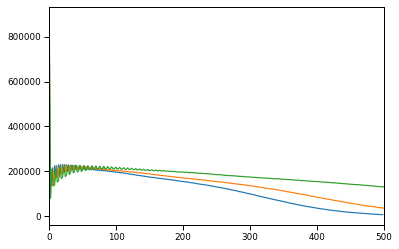

In [273]:
plt.plot(extcounts0)
plt.plot(extcounts1)
plt.plot(extcounts2)
plt.xlim(0,500)

In [299]:
(totalforcing_land[99] - totalforcing_land[0]) / totalforcing_land[0]

0.4488531584372386

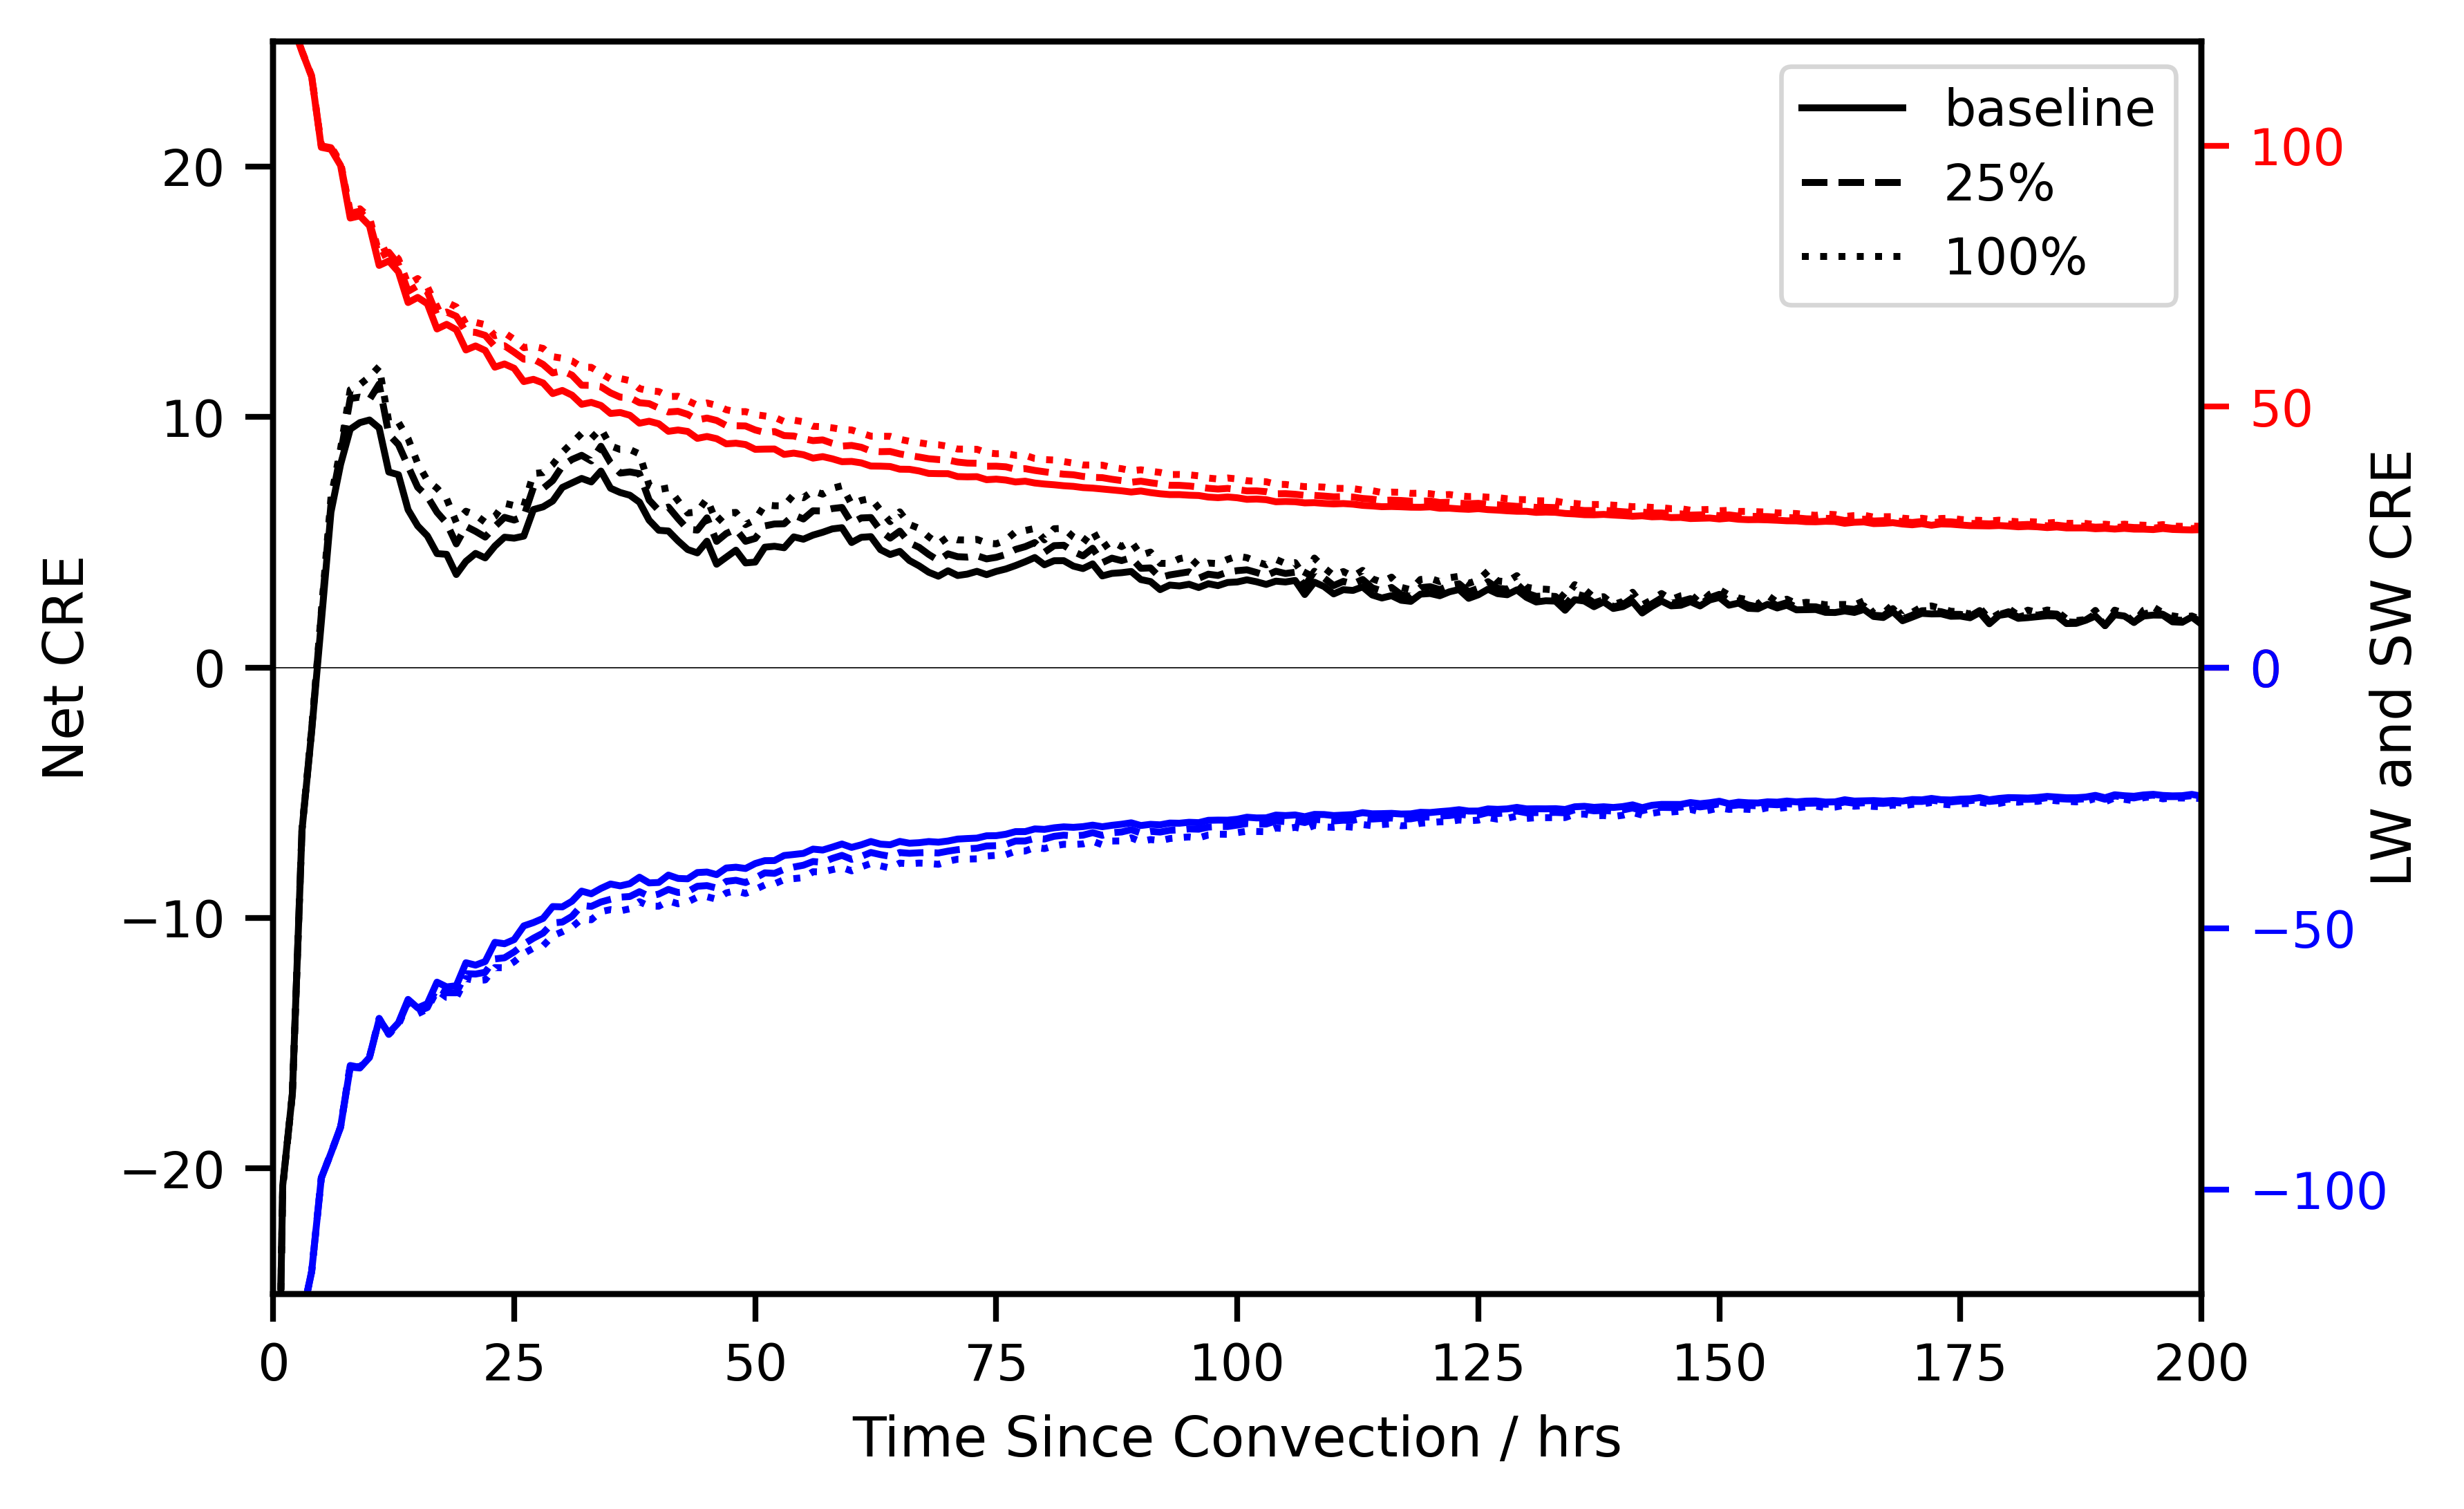

In [250]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_context('paper')

fig, host = plt.subplots(figsize=(6,4),dpi=600) # (width, height) in inches

ax2 = host.twinx()
ax3 = host.twinx()
    
host.set_xlim(0, 200)
host.set_ylim(-25,25)


    
host.set_xlabel("Time Since Convection / hrs")
host.set_ylabel("Net CRE")

ax2.set_ylabel("LW and SW CRE")
#ax3.set_ylabel("SW CRE")
p1 = host.plot(weightedlw0+weightedsw0,    color='black', label="baseline")
p2 = host.plot(weightedlw1+weightedsw1,    color='black',linestyle='--' ,label="25%")
p3 = host.plot(weightedlw2+weightedsw2,    color='black',linestyle=':' ,label="100%")

p4 = ax2.plot(weightedlw0, color='red',linestyle='-',label="baseline")
p5 = ax2.plot(weightedlw1, color='red',linestyle='--', label="25%")
p6 = ax2.plot(weightedlw2,color='red',linestyle=':',label='100%')

ax2.set_ylim(-120,120)
ax3.set_ylim(-120,120)

p7 = ax2.plot(weightedsw0, color='blue',linestyle='-',label="baseline")
p8 = ax2.plot(weightedsw1, color='blue',linestyle='--', label="25%")
p9 = ax2.plot(weightedsw2,color='blue',linestyle=':',label='100%')


host.legend(handles=p1+p2+p3, loc='best')

ax2.set_yticks([0,50,100])
ax3.set_yticks([-100,-50,0])
ax3.axhline(0,color='k',linewidth=0.2)

host.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax2.tick_params(axis='y', colors='red')
ax3.tick_params(axis='y', colors='blue')
plt.savefig('/disk1/Users/gah20/LifeTimePaper/lifetime_cre_tsc.pdf',bbox_inches='tight',dpi=700)


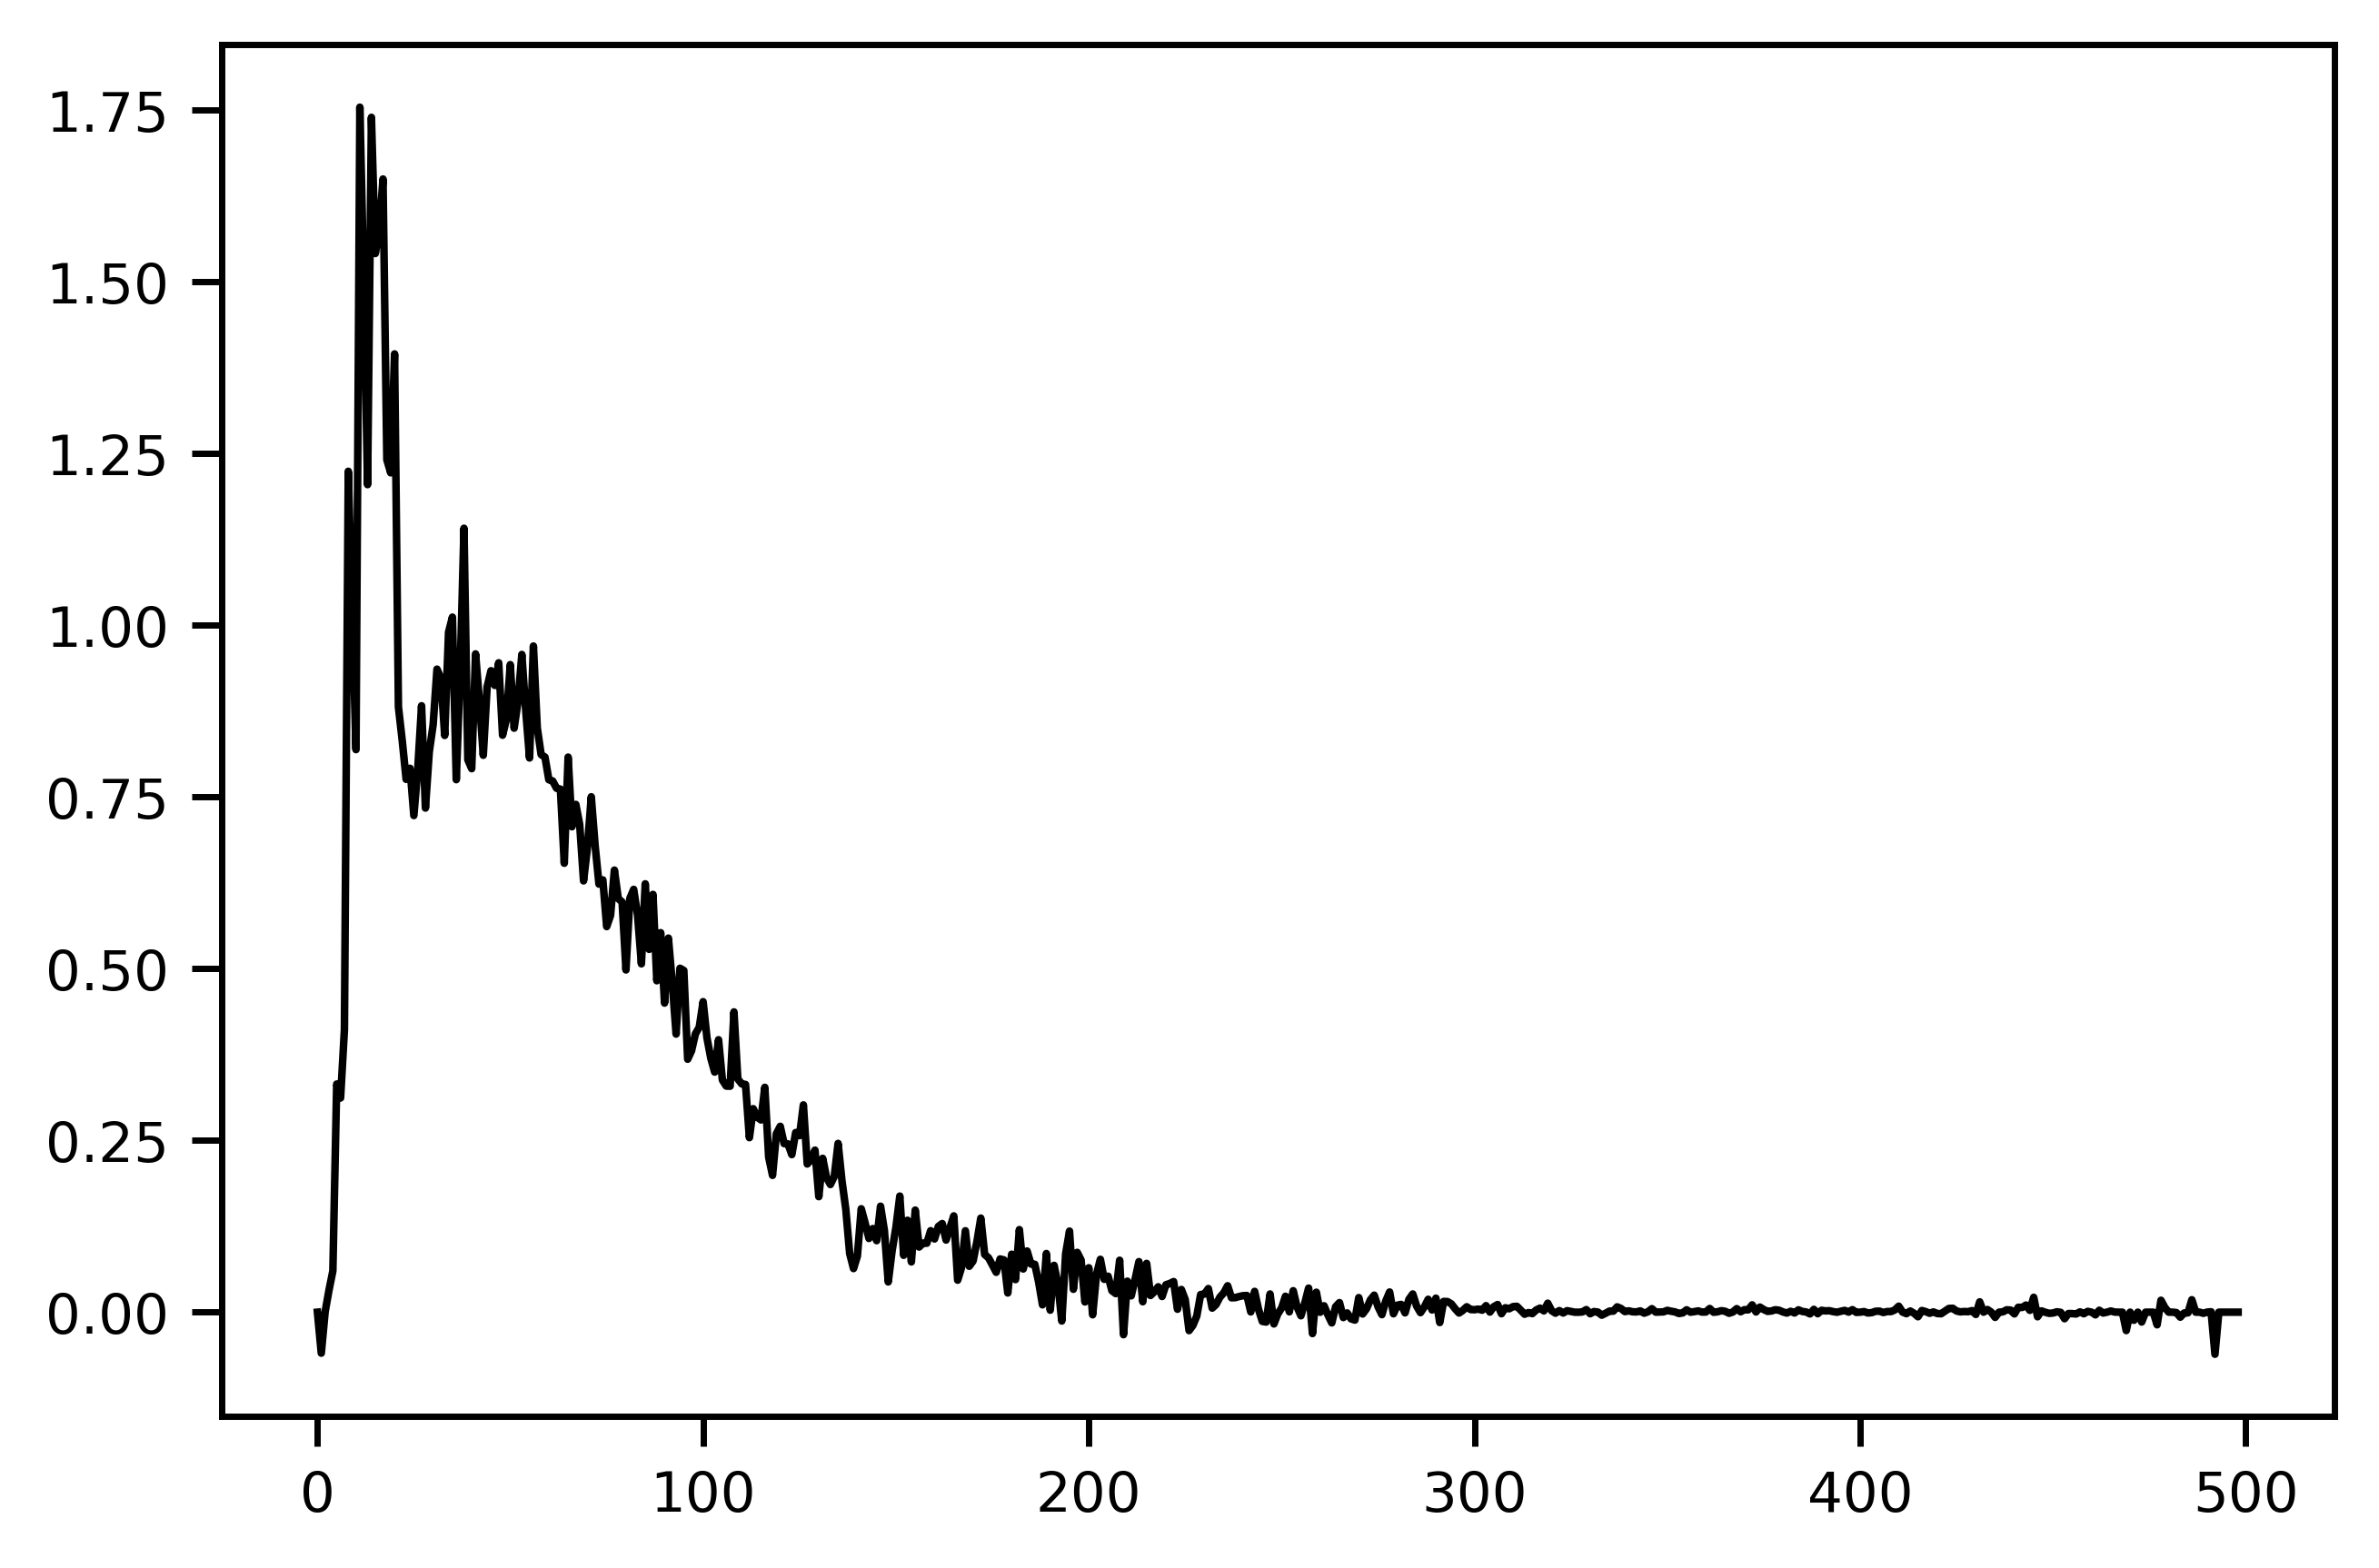

In [265]:
plt.figure(dpi=500,figsize=(6,4))


plt.plot((weightedlw1+weightedsw1) - (weightedlw0+weightedsw0),color='black')


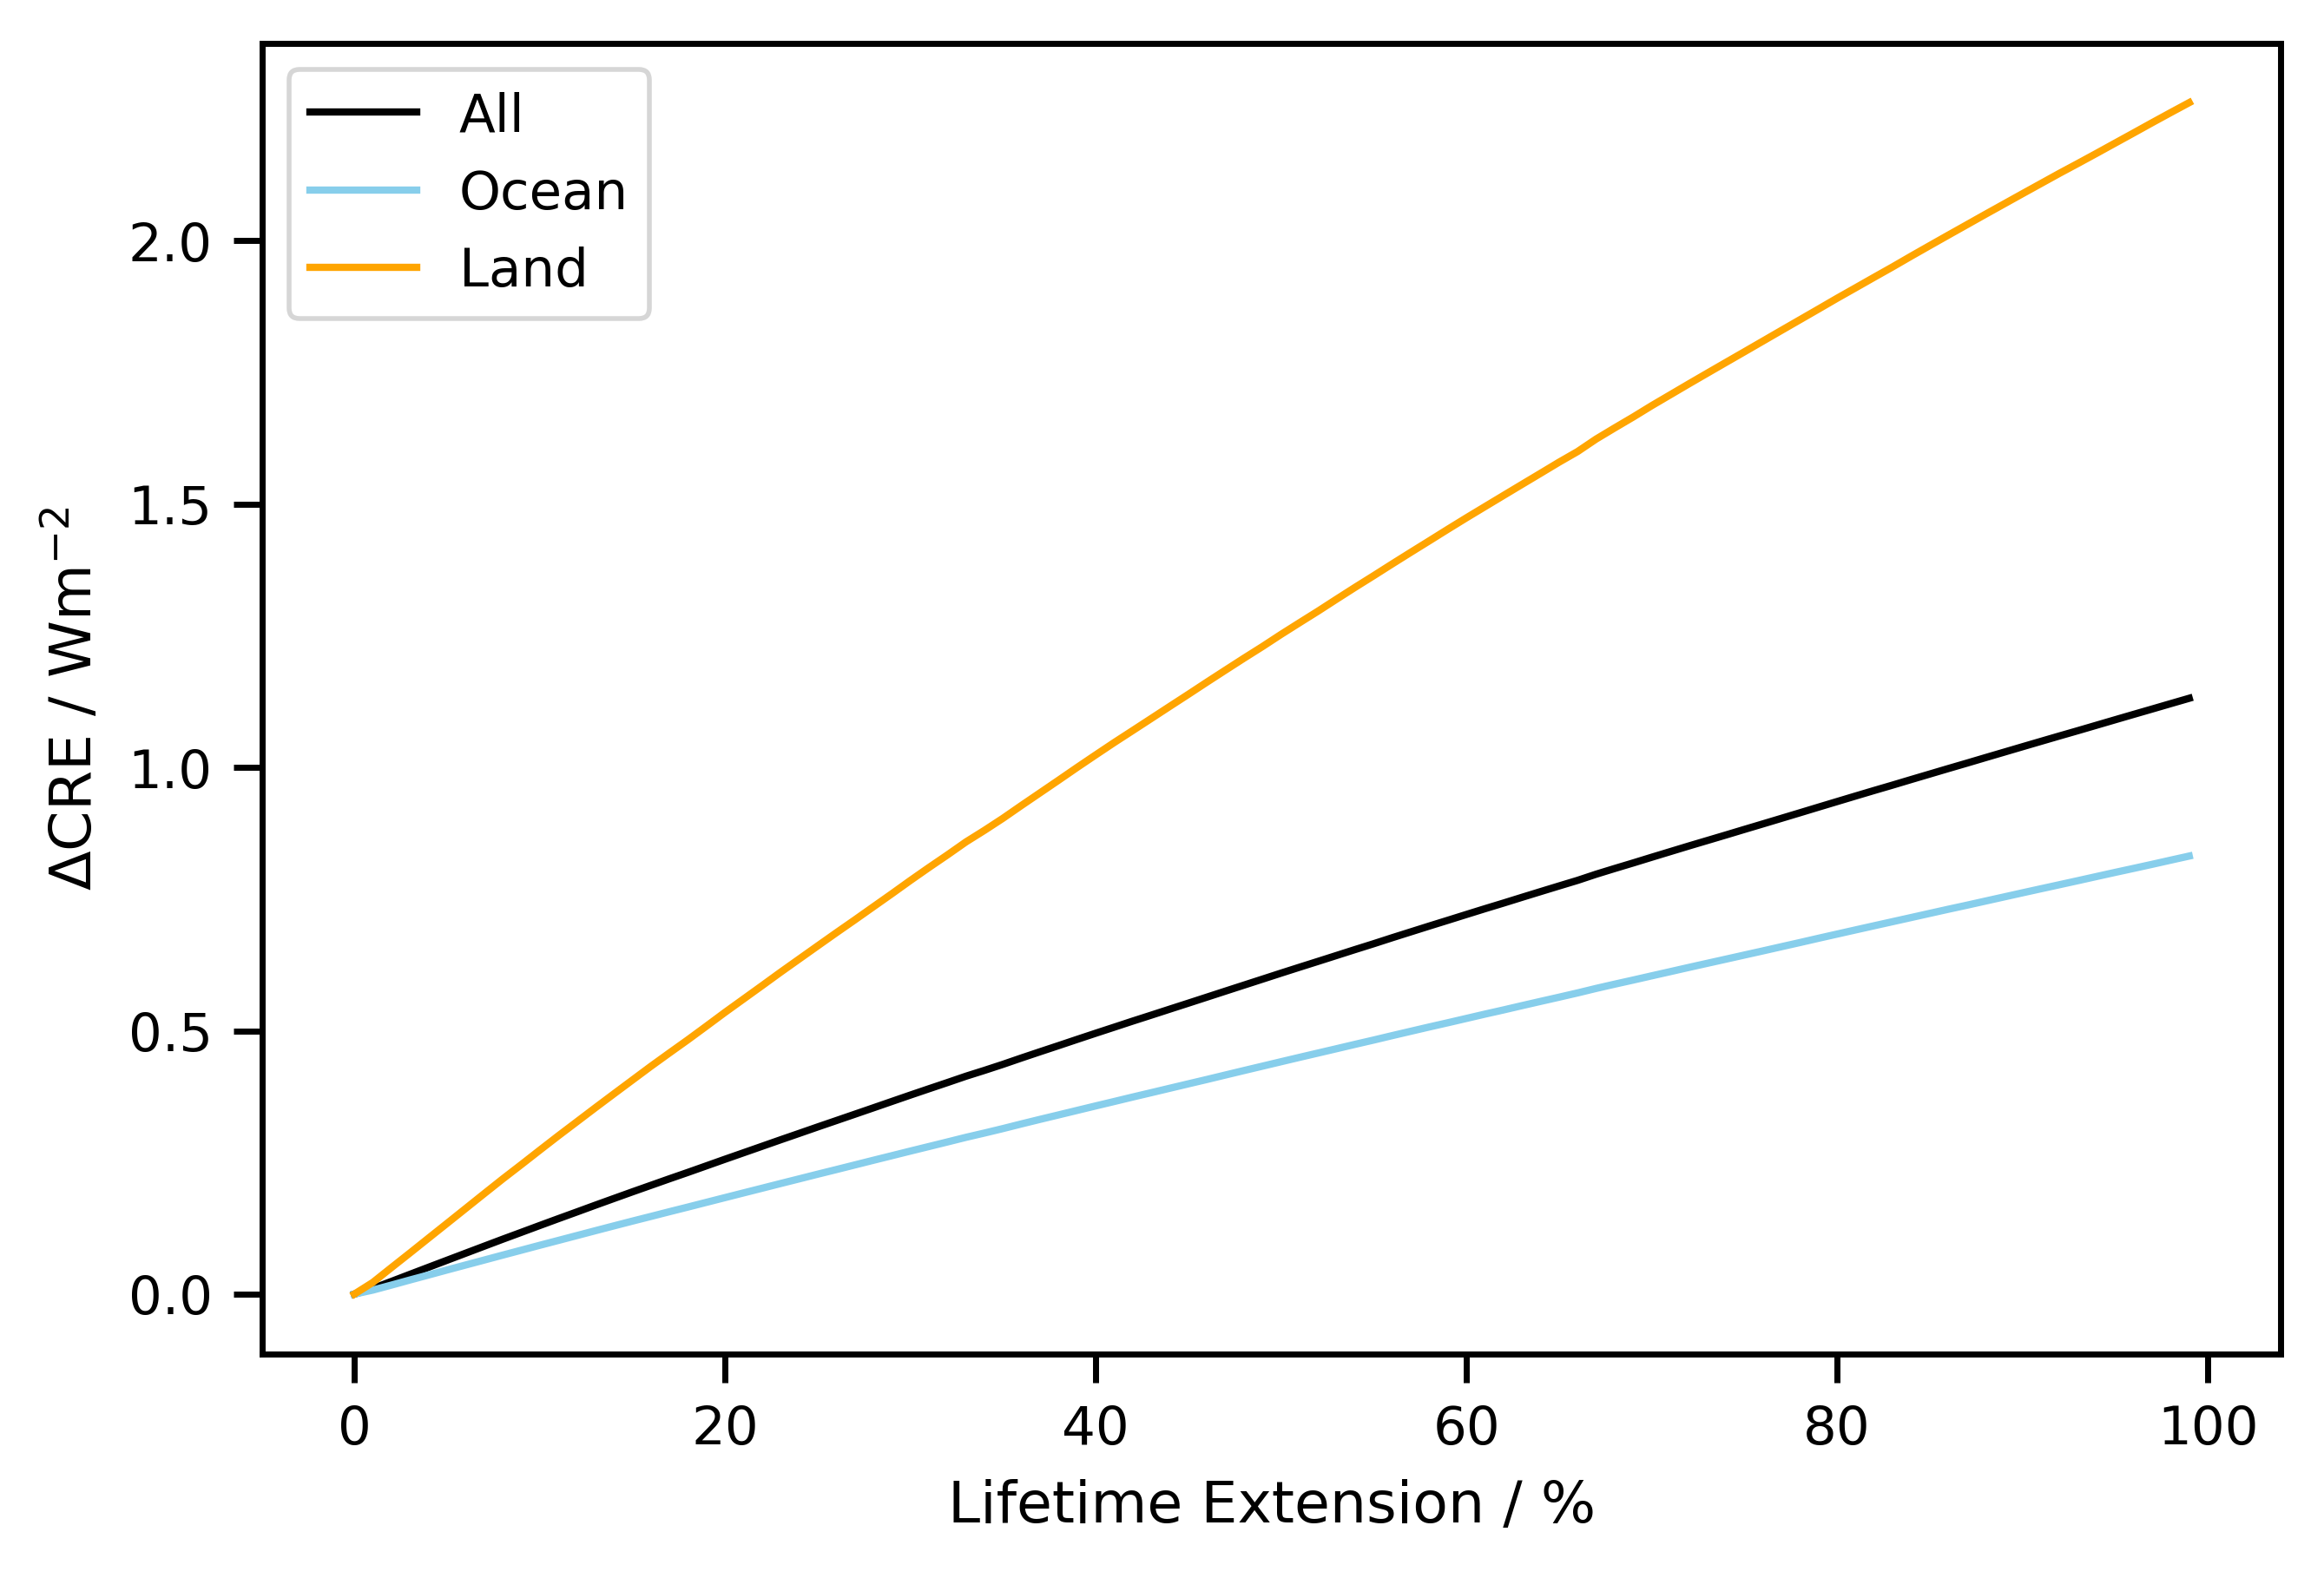

In [274]:
plt.figure(dpi=500)
sns.set_context('paper')
plt.plot(totalforcing-totalforcing[0],label='All',color='k')
plt.plot(totalforcing_ocean-totalforcing_ocean[0],label='Ocean',color='skyblue')
plt.plot(totalforcing_land-totalforcing_land[0],label='Land',color='orange')
plt.xlabel('Lifetime Extension / %')
plt.ylabel('$\Delta$CRE / Wm$^{-2}$')
plt.legend()
plt.savefig('forcing_albedo_change.pdf',bbox_inches='tight')

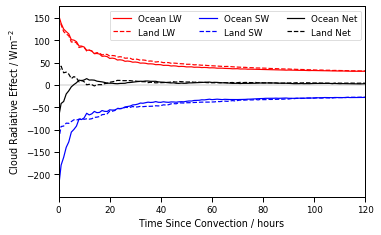

In [51]:
plt.figure(figsize=(5.5,3.5))
sns.set_context('paper')
plt.plot(LW_AVERAGE_o,label='Ocean LW',color='red')
plt.plot(LW_AVERAGE_l,label='Land LW',color='red',linestyle='dashed')

plt.plot(SW_AVERAGE_o,label='Ocean SW',color='blue')
plt.plot(SW_AVERAGE_l,label='Land SW',color='blue',linestyle='dashed')

plt.plot(SW_AVERAGE_o+LW_AVERAGE_o,label='Ocean Net',color='black')
plt.plot(SW_AVERAGE_l+LW_AVERAGE_l,label='Land Net',color='black',linestyle='dashed')

plt.xlabel('Time Since Convection / hours')
plt.ylabel('Cloud Radiative Effect / Wm$^{-2}$')
plt.axhline(0,color='k',linewidth=0.2)
plt.legend(ncol=3)
plt.xlim(0,120)
plt.savefig('forcing_landocean.pdf',bbox_inches='tight',dpi=700)


In [85]:
tscnan = np.where(tsc.astype(int)<0,False,tsc.astype(int))
tscnanv2 = np.where(tscnan>498,False,tscnan)

lwnan = np.where(np.isnan(tsc),np.nan,LW_AVERAGE_all[tscnanv2])
lwnanv2 = np.where(np.isnan(tsc),np.nan,np.where(tsc>498,np.nan,lwnan))


swnan = np.where(np.isnan(tsc),np.nan,SW_AVERAGE_all[tscnanv2])
swnanv2 = np.where(np.isnan(tsc),np.nan,np.where(tsc>498,np.nan,swnan))

#----------------------------------------------------------------------------------------------------------------------------

lwnan = np.where(np.isnan(tsc),np.nan,weightedlw[tscnanv2])
lwnanv2_ext = np.where(np.isnan(tsc),np.nan,np.where(tsc>498,np.nan,lwnan))


swnan = np.where(np.isnan(tsc),np.nan,weightedsw[tscnanv2])
swnanv2_ext = np.where(np.isnan(tsc),np.nan,np.where(tsc>498,np.nan,swnan))

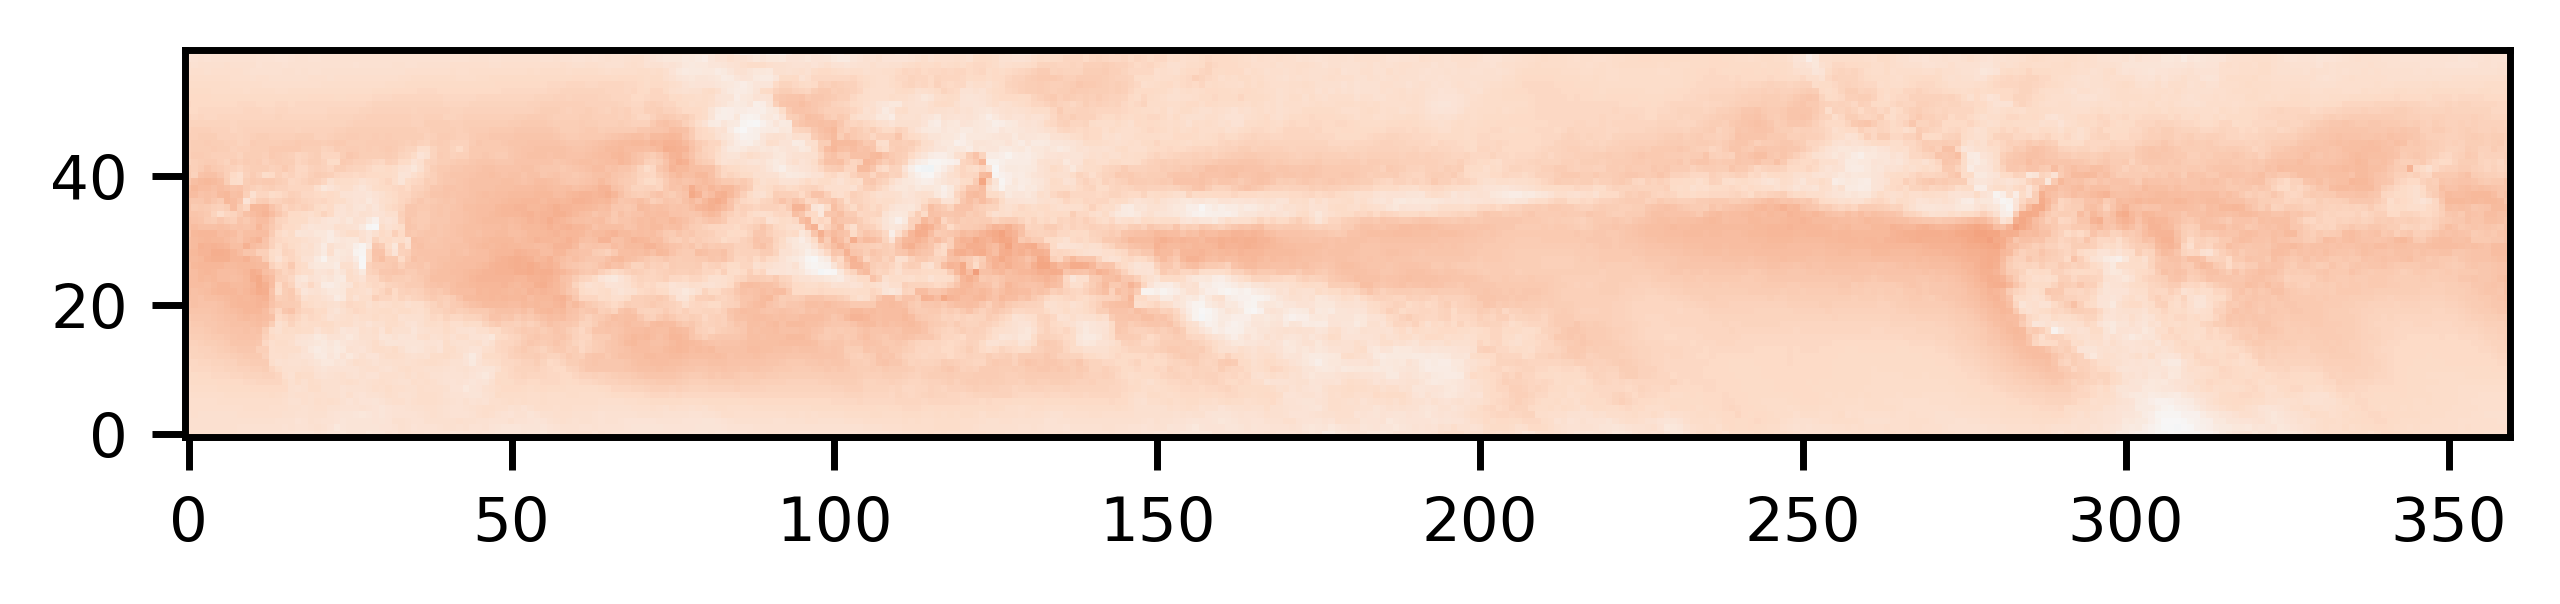

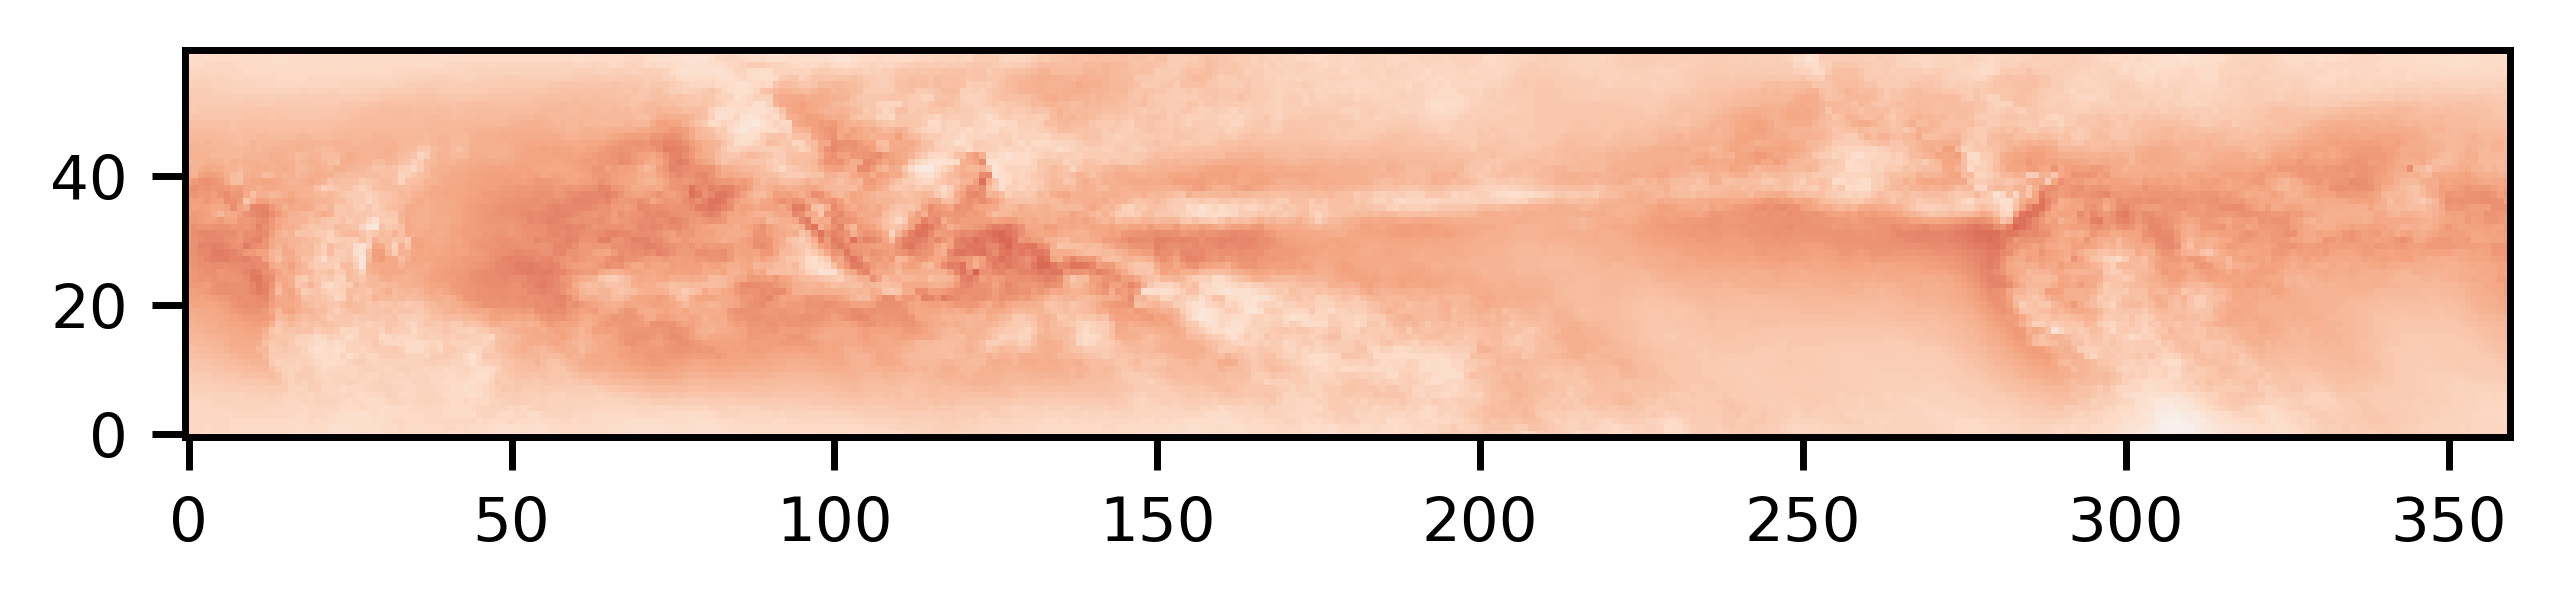

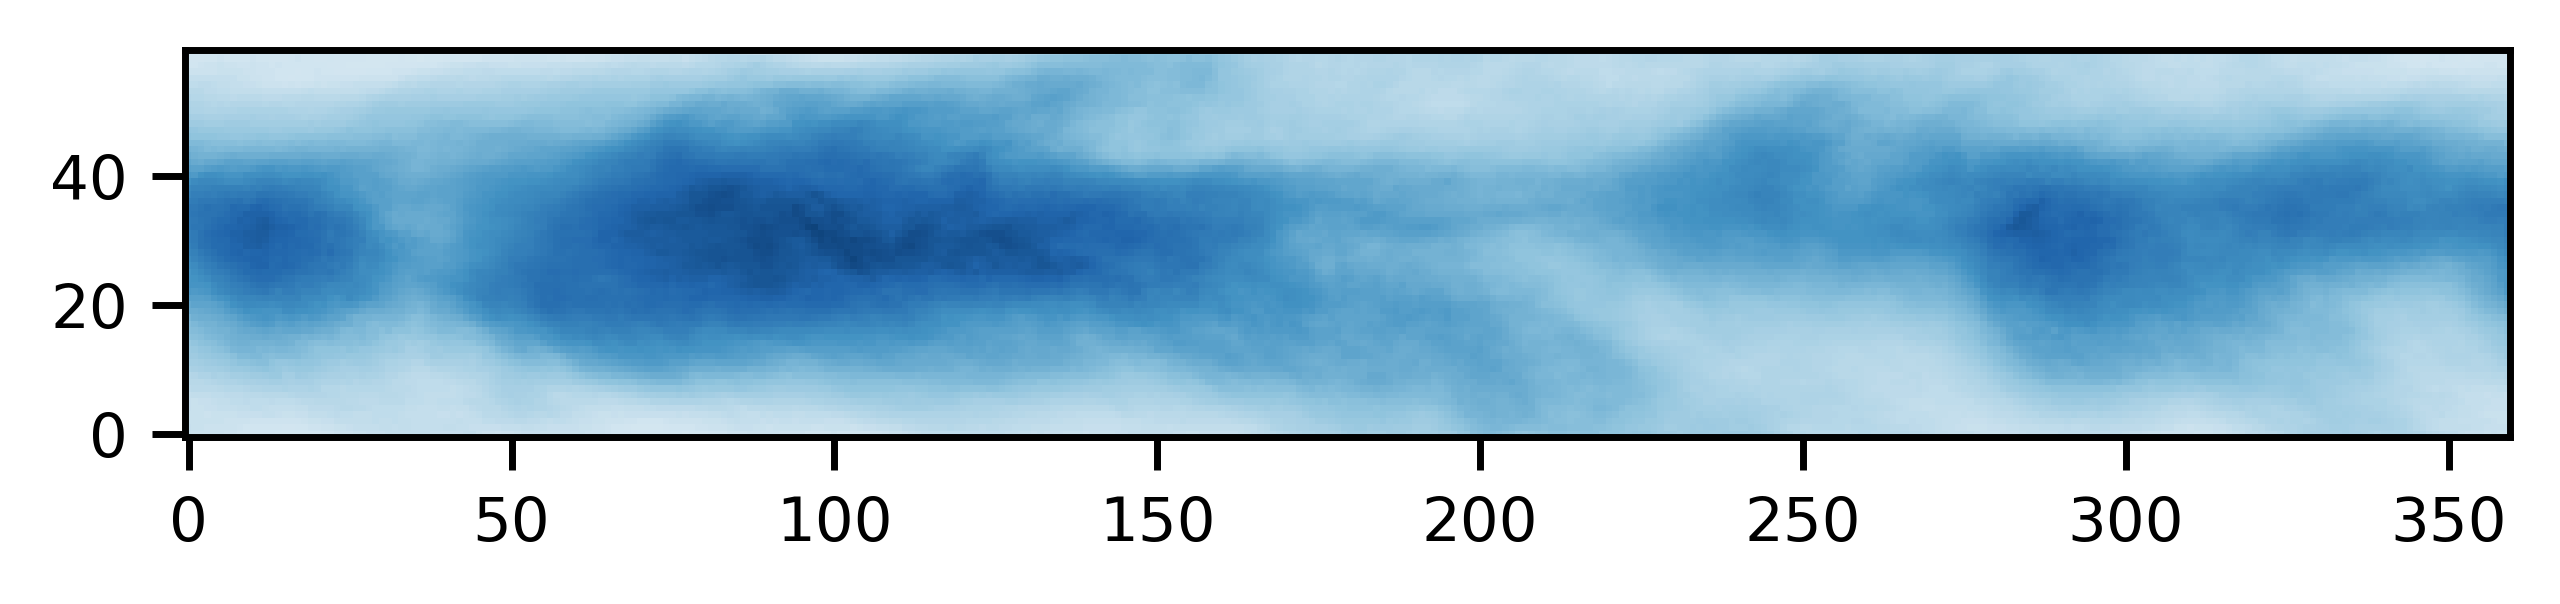

In [90]:
plt.figure(dpi=500)
plt.imshow(np.nanmean(lwnanv2,axis=0)+np.nanmean(swnanv2,axis=0),origin='lower',cmap='RdBu_r',vmax=10,vmin=-10)
plt.figure(dpi=500)
plt.imshow(np.nanmean(lwnanv2_ext,axis=0)+np.nanmean(swnanv2_ext,axis=0),origin='lower',cmap='RdBu_r',vmax=10,vmin=-10)

plt.figure(dpi=500)
plt.imshow((np.nanmean(lwnanv2,axis=0)+np.nanmean(swnanv2,axis=0)) - (np.nanmean(lwnanv2_ext,axis=0)+np.nanmean(swnanv2_ext,axis=0)),origin='lower',cmap='RdBu_r',vmax=2,vmin=-2)

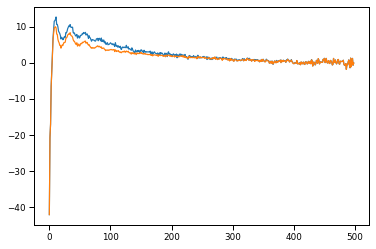

In [84]:
plt.plot(weightedlw+weightedsw)
plt.plot(LW_AVERAGE_all+SW_AVERAGE_all)

### DIURNAL PLOTS

In [8]:
isccp = xr.open_mfdataset('/disk1/Data/ISCCP/access/isccp-basic/hgg/200001/out.nc',combine='nested',concat_dim='time')
taupc = isccp['n_pctaudist']
levtau = isccp['levtau']
levpc = isccp['levpc']
tauraw = isccp['tau']
pcraw = isccp['pc']
isccptime = isccp['time']

In [10]:
isccptime

<xarray.DataArray 'time' (time: 248)>
array(['2000-01-01T00:00:00.000000000', '2000-01-01T03:00:00.000000000',
       '2000-01-01T06:00:00.000000000', ..., '2000-01-31T15:00:00.000000000',
       '2000-01-31T18:00:00.000000000', '2000-01-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-31T21:00:00
Attributes:
    long_name:     Time
    bounds:        time_bounds
    cell_methods:  time: mean